## Prepare Notebook

In [1]:
import arviz as az
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import seaborn as sns

from jax import random
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoNormal
from numpyro.infer.util import initialize_model, Predictive
from sklearn.preprocessing import StandardScaler


az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Generate Synthetic Data

In [2]:
n = 200
rng_key, rng_subkey = random.split(rng_key)
x = random.uniform(rng_key, shape=(n,), minval=1, maxval=jnp.pi)
mu_true = jnp.sqrt(x + 0.5) * jnp.sin(9 * x)
sigma_true = 0.15 * x**2
rng_key, rng_subkey = random.split(rng_key)
y = mu_true + sigma_true * random.normal(rng_key, shape=(n,))

[Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

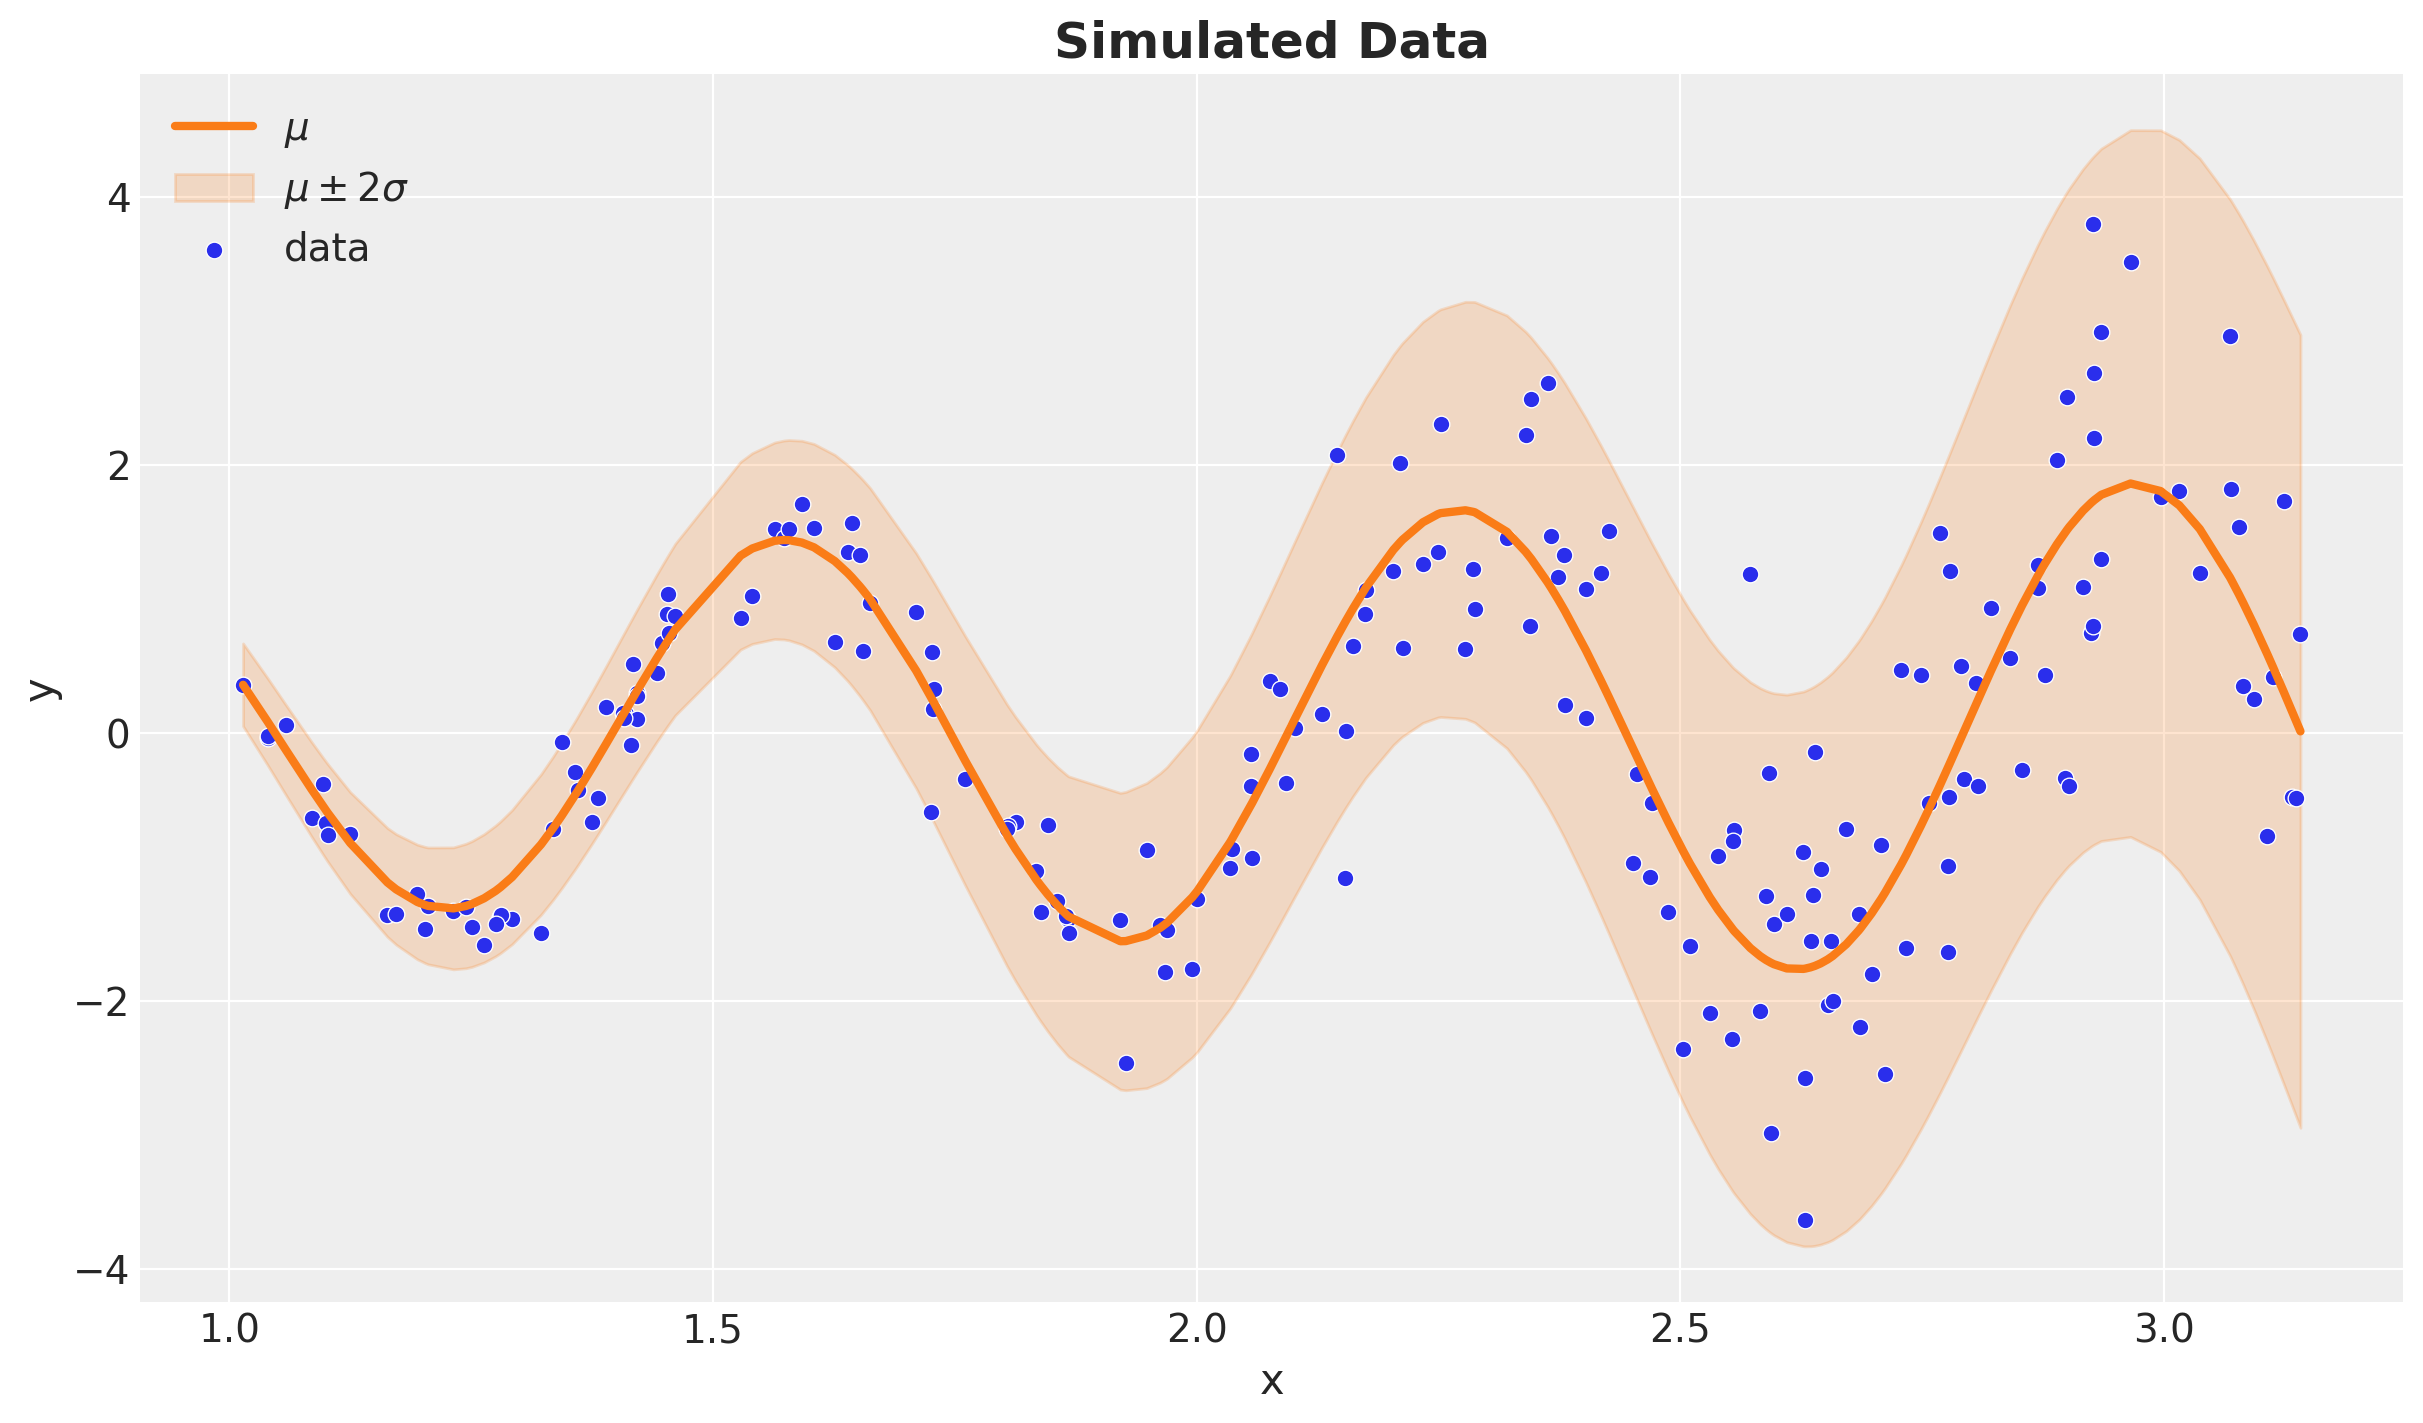

In [3]:
x_idx = jnp.argsort(x)

fig, ax = plt.subplots()
sns.lineplot(x=x, y=mu_true, color="C1", label=r"$\mu$", linewidth=3, ax=ax)
ax.fill_between(
    x[x_idx],
    (mu_true - 2 * sigma_true)[x_idx],
    (mu_true + 2 * sigma_true)[x_idx],
    color="C1",
    alpha=0.2,
    label=r"$\mu \pm 2 \sigma$",
)
sns.scatterplot(x=x, y=y, color="C0", label="data", ax=ax)
ax.legend(loc="upper left")
ax.set_title(label="Simulated Data", fontsize=18, fontweight="bold")
ax.set(xlabel="x", ylabel="y")

In [4]:
train_test_split = 0.7
train_idx = int(n * train_test_split)
x_train, y_train = x[:train_idx], y[:train_idx]
x_test, y_test = x[train_idx:], y[train_idx:]

[Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

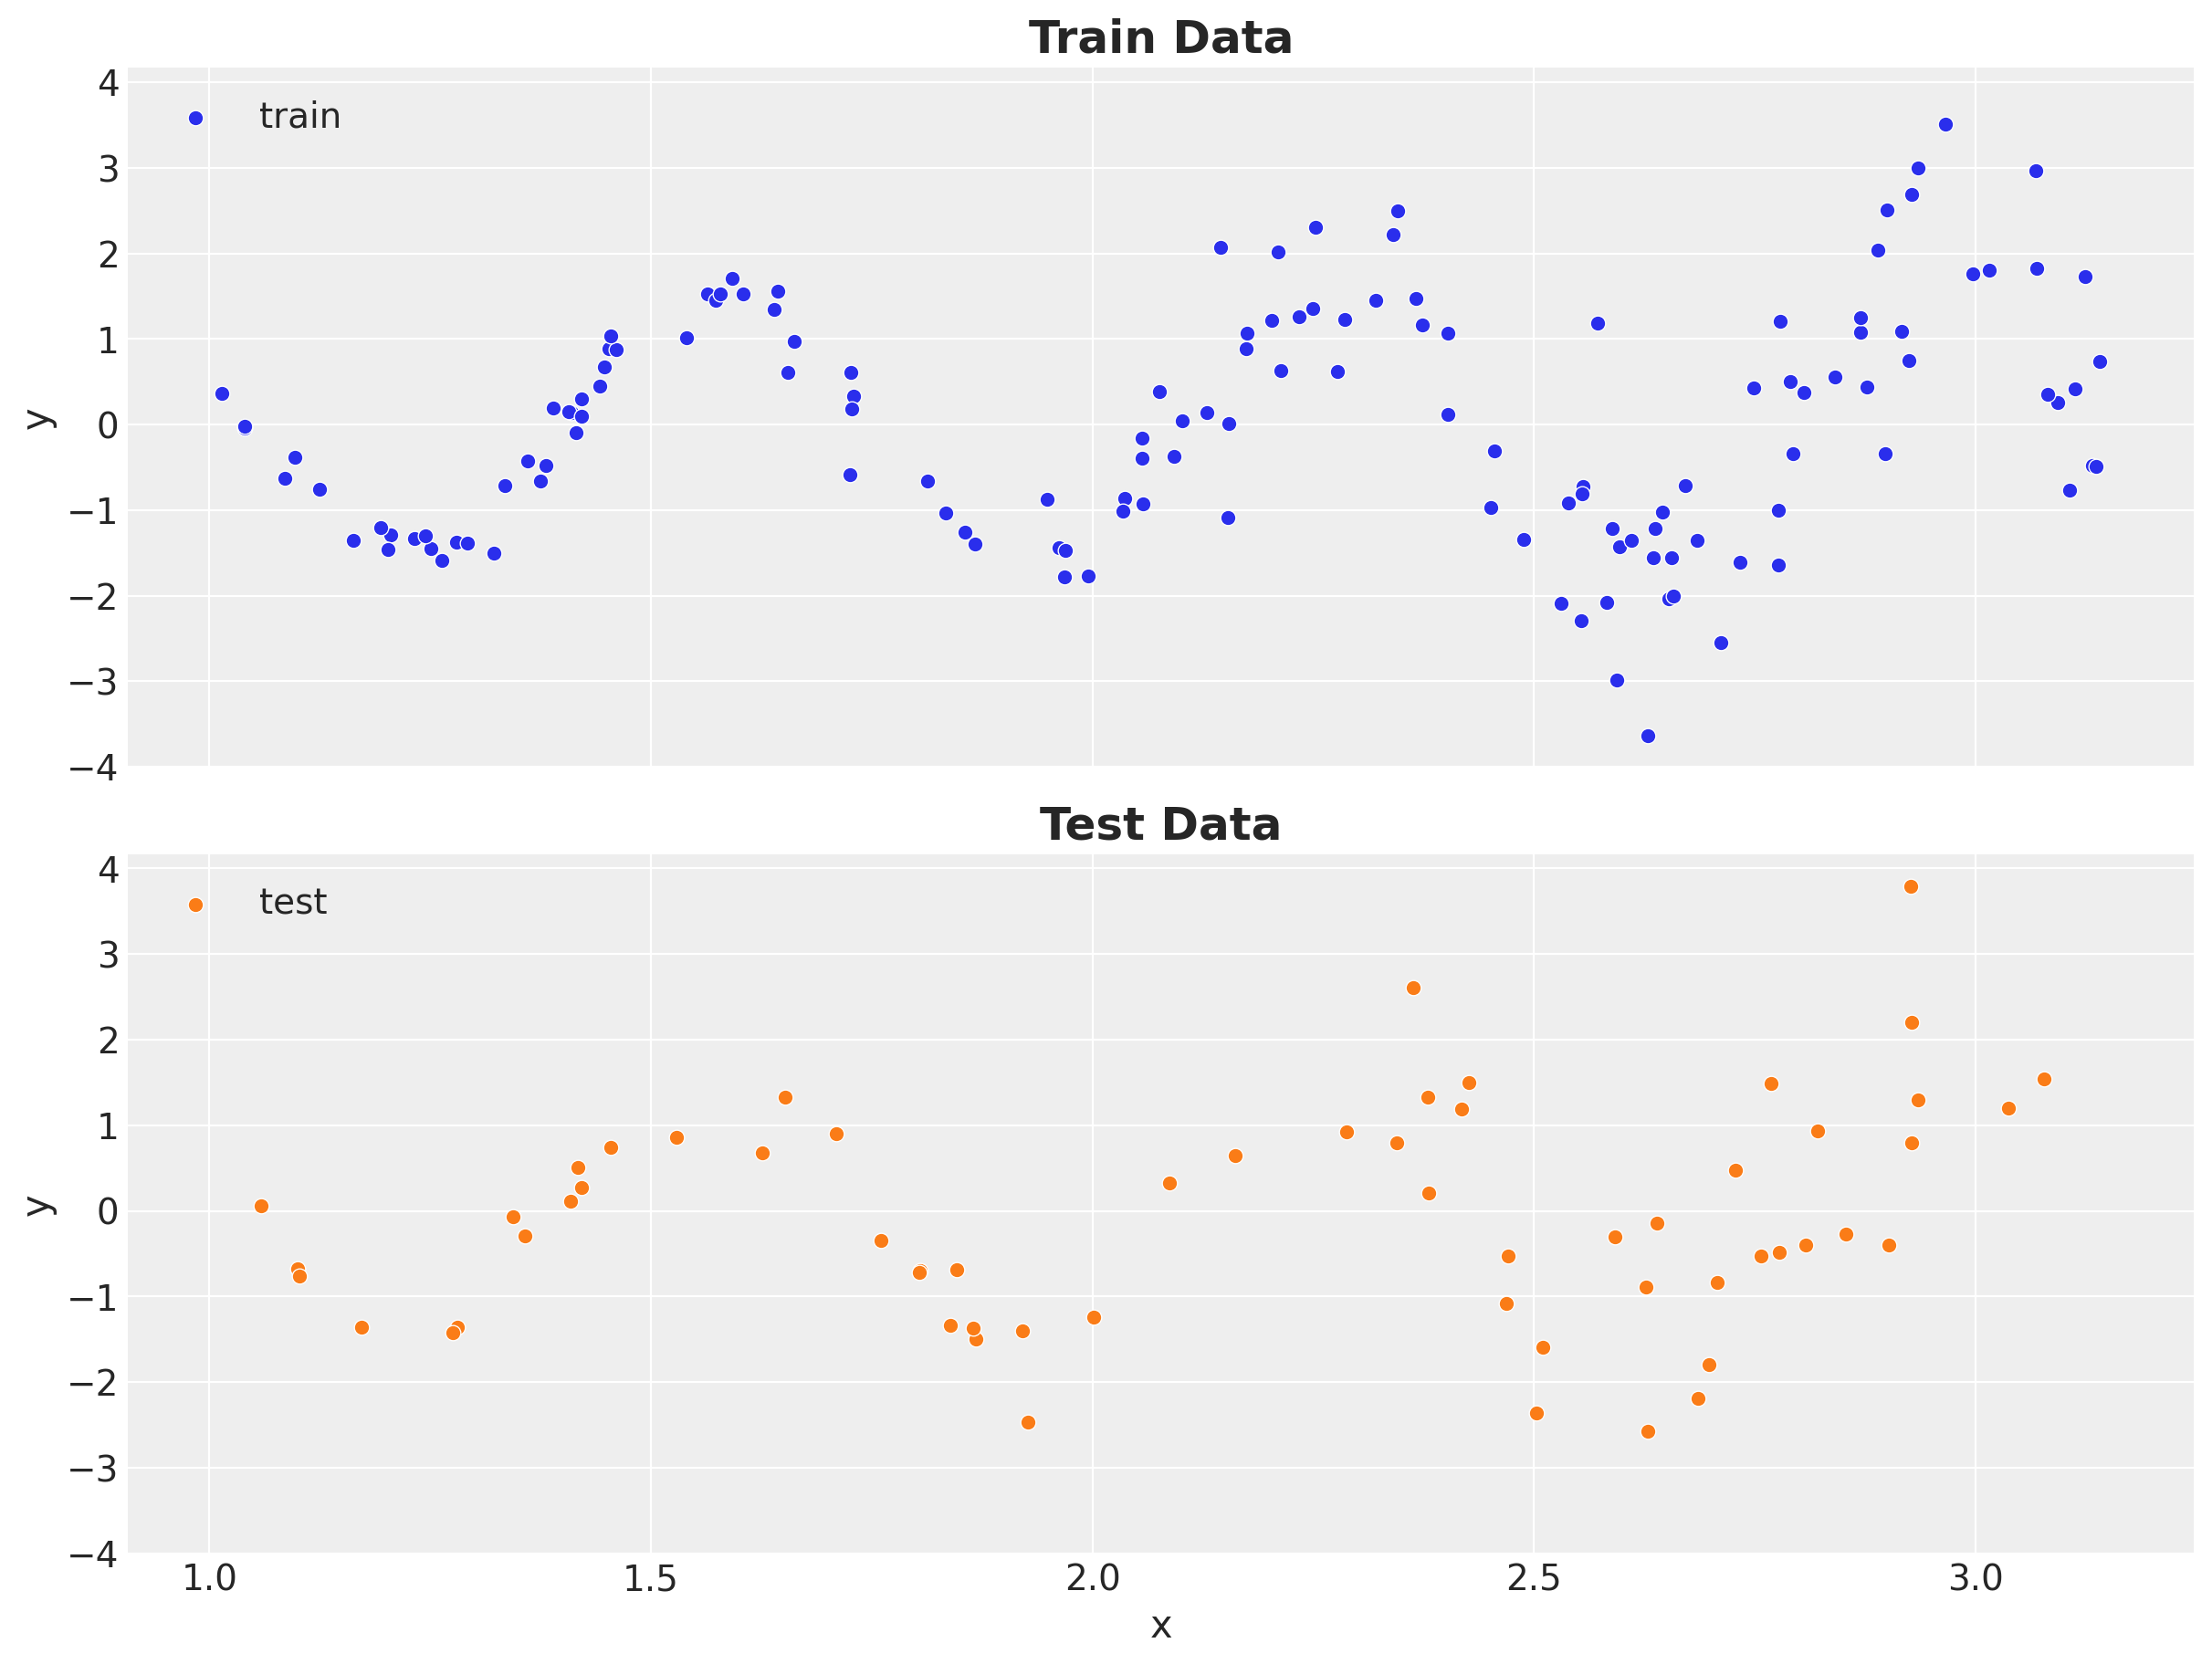

In [5]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, sharex=True, sharey=True, figsize=(12, 9), layout="constrained"
)
sns.scatterplot(x=x_train, y=y_train, color="C0", label="train", ax=ax[0])
ax[0].legend(loc="upper left")
ax[0].set_title(label="Train Data", fontsize=18, fontweight="bold")
ax[0].set(xlabel="x", ylabel="y")
sns.scatterplot(x=x_test, y=y_test, color="C1", label="test", ax=ax[1])
ax[1].legend(loc="upper left")
ax[1].set_title(label="Test Data", fontsize=18, fontweight="bold")
ax[1].set(xlabel="x", ylabel="y")

## Data Preprocessing

In [6]:
x_scaler = StandardScaler()
x_train_scaled = x_scaler.fit_transform(x_train[:, None])
x_train_scaled = x_train_scaled.squeeze()
x_test_scaled = x_scaler.transform(x_test[:, None])
x_test_scaled = x_test_scaled.squeeze()

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train[:, None])
y_train_scaled = y_train_scaled.squeeze()
y_test_scaled = y_scaler.transform(y_test[:, None])
y_test_scaled = y_test_scaled.squeeze()

[Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

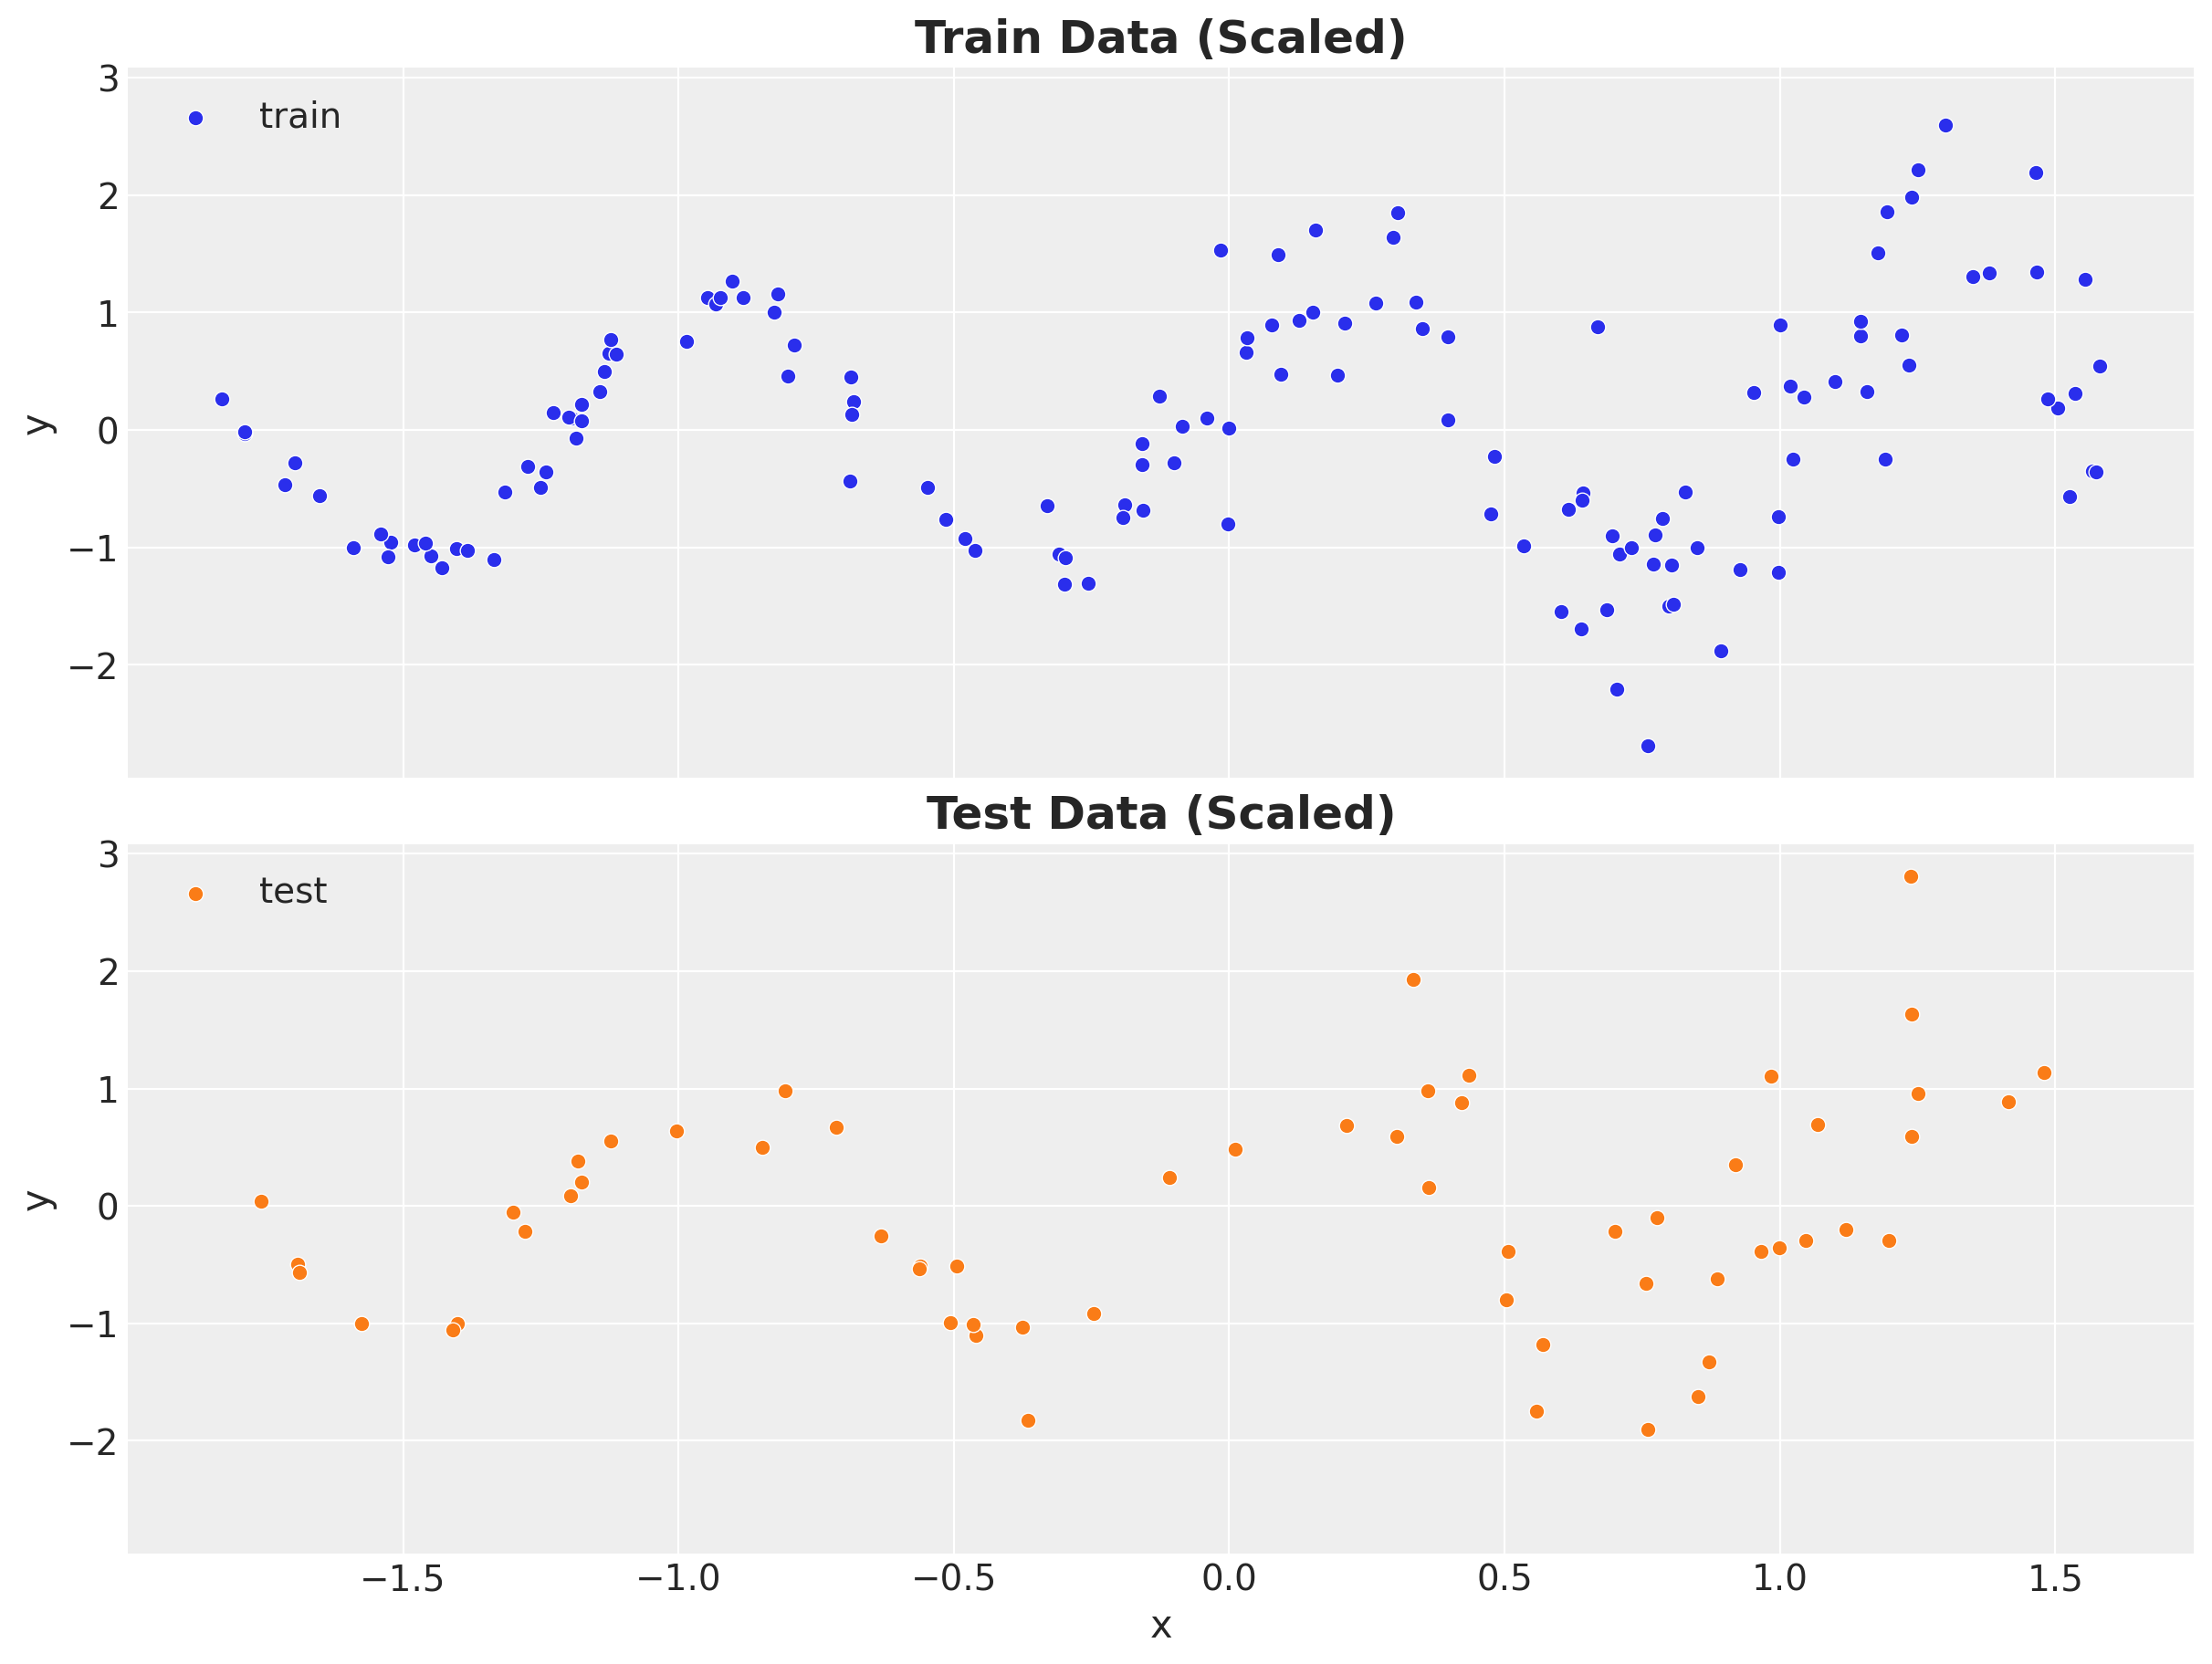

In [7]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, sharex=True, sharey=True, figsize=(12, 9), layout="constrained"
)
sns.scatterplot(x=x_train_scaled, y=y_train_scaled, color="C0", label="train", ax=ax[0])
ax[0].legend(loc="upper left")
ax[0].set_title(label="Train Data (Scaled)", fontsize=18, fontweight="bold")
ax[0].set(xlabel="x", ylabel="y")
sns.scatterplot(x=x_test_scaled, y=y_test_scaled, color="C1", label="test", ax=ax[1])
ax[1].legend(loc="upper left")
ax[1].set_title(label="Test Data (Scaled)", fontsize=18, fontweight="bold")
ax[1].set(xlabel="x", ylabel="y")

## Model Training

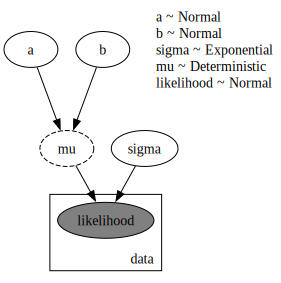

In [8]:
def model(x, y=None):
    a = numpyro.sample("a", dist.Normal(loc=0.0, scale=1.0))
    b = numpyro.sample("b", dist.Normal(loc=0.0, scale=1.0))
    sigma = numpyro.sample("sigma", dist.Exponential(rate=1.0))
    mu = numpyro.deterministic("mu", a + b * x)
    with numpyro.plate("data", len(x)):
        numpyro.sample("likelihood", dist.Normal(mu, sigma), obs=y)


numpyro.render_model(
    model=model,
    model_args=(x_train_scaled, y_train_scaled),
    render_distributions=True,
    render_params=True,
)

100%|██████████| 1000/1000 [00:01<00:00, 785.79it/s, init loss: 953.7768, avg. loss [951-1000]: 204.8957]


Text(0.5, 1.0, 'ELBO loss')

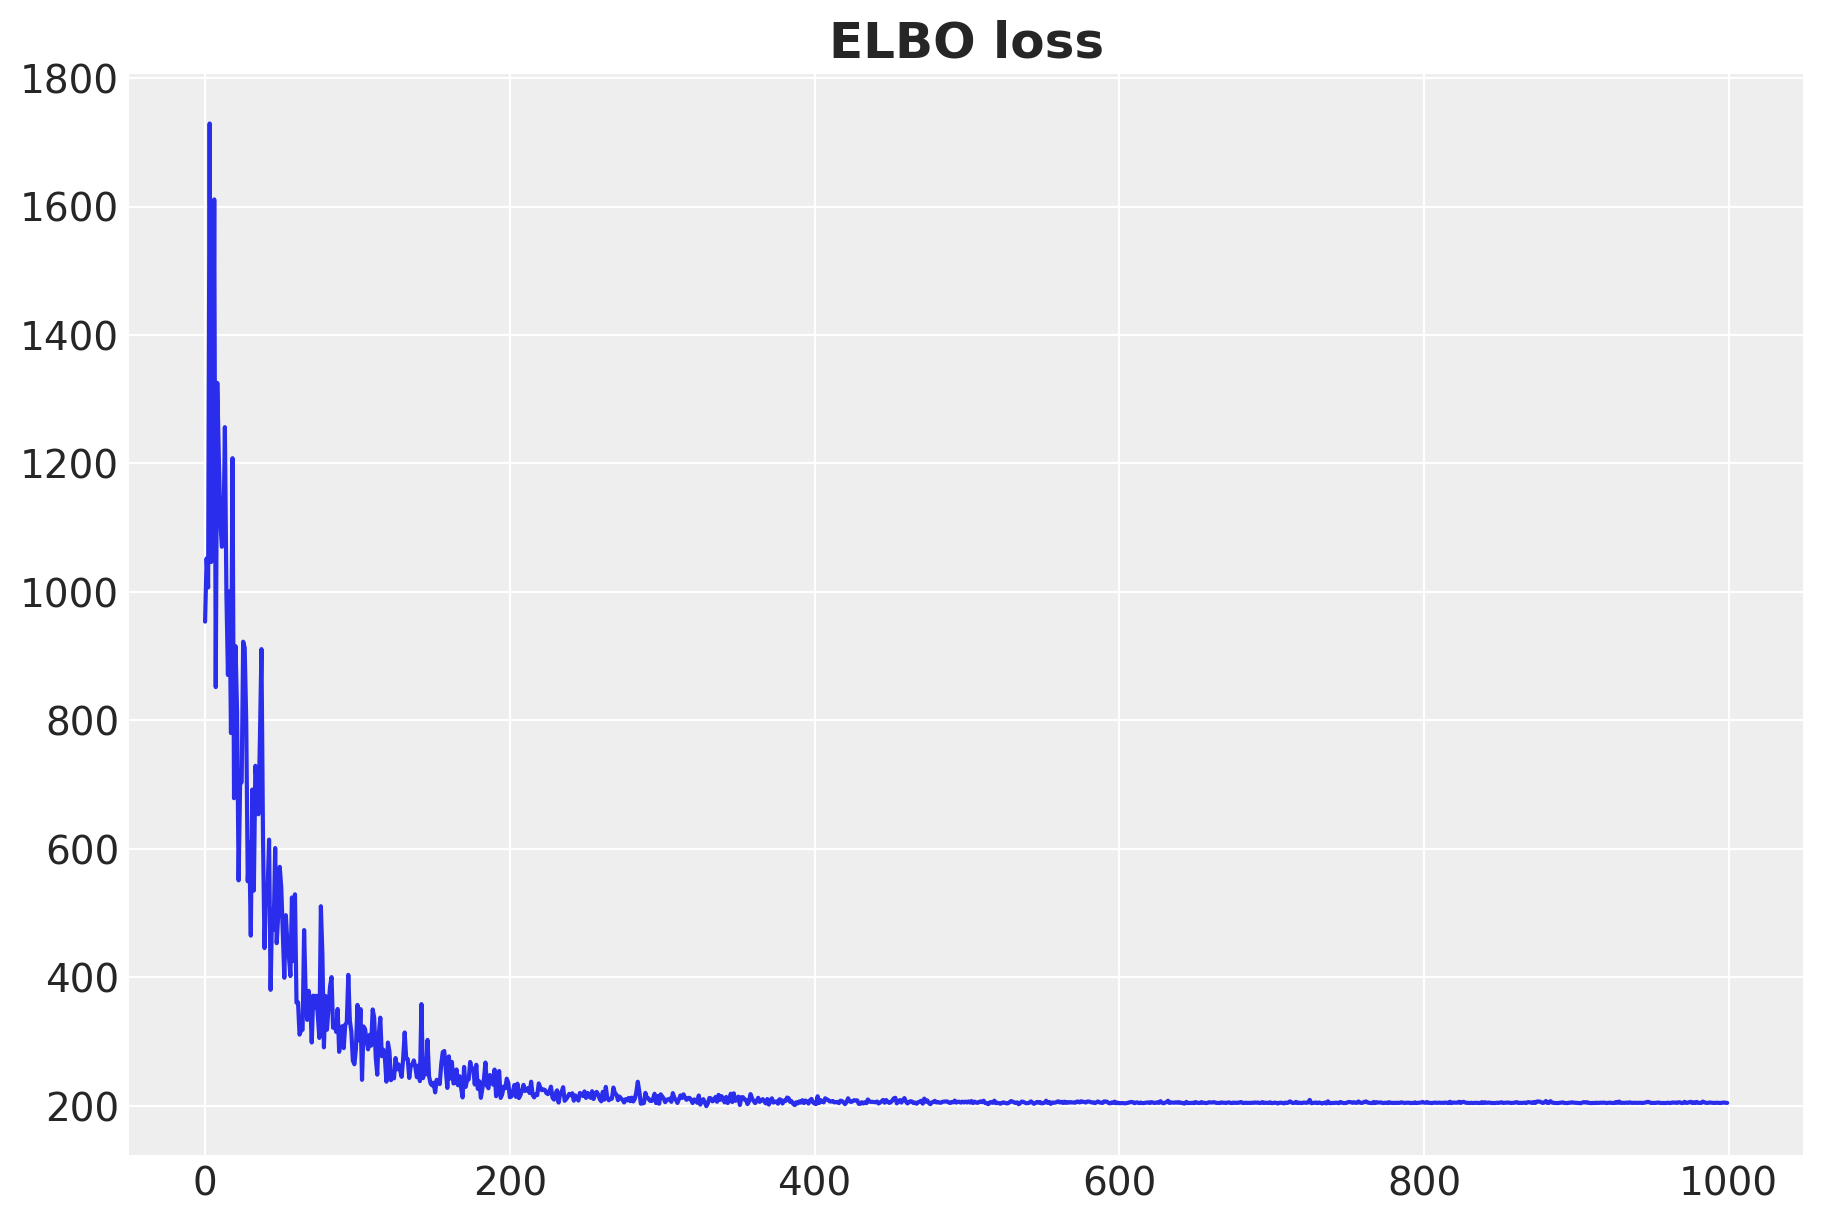

In [9]:
guide = AutoNormal(model=model)
optimizer = numpyro.optim.Adam(step_size=0.01)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
rng_key, rng_subkey = random.split(key=rng_key)
n_samples = 1_000
svi_result = svi.run(rng_subkey, n_samples, x_train_scaled, y_train_scaled)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(svi_result.losses)
ax.set_title("ELBO loss", fontsize=18, fontweight="bold")

In [10]:
params = svi_result.params
# get posterior samples (parameters)
predictive = Predictive(model=guide, params=params, num_samples=4_000)
rng_key, rng_subkey = random.split(key=rng_key)
posterior_samples = predictive(rng_subkey, x_train_scaled, y_train_scaled)
# get posterior predictive (deterministics and likelihood)
predictive = Predictive(model=model, guide=guide, params=params, num_samples=4_000)
rng_key, rng_subkey = random.split(key=rng_key)
samples = predictive(rng_subkey, x_train_scaled)

In [11]:
idata_svi = az.from_dict(
    posterior={
        k: np.expand_dims(a=np.asarray(v), axis=0) for k, v in posterior_samples.items()
    },
    posterior_predictive={
        k: np.expand_dims(a=np.asarray(v), axis=0) for k, v in samples.items()
    },
)

In [12]:
az.summary(data=idata_svi, var_names=["a", "b", "sigma"], round_to=3)

arviz - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.001,0.086,-0.155,0.169,0.001,0.001,3716.227,3868.153,NaN
b,0.151,0.083,-0.003,0.310,0.001,0.001,4036.385,3881.162,NaN
sigma,1.005,0.079,0.856,1.152,0.001,0.001,3996.806,4001.518,NaN


Text(0.5, 0.98, 'SVI Trace')

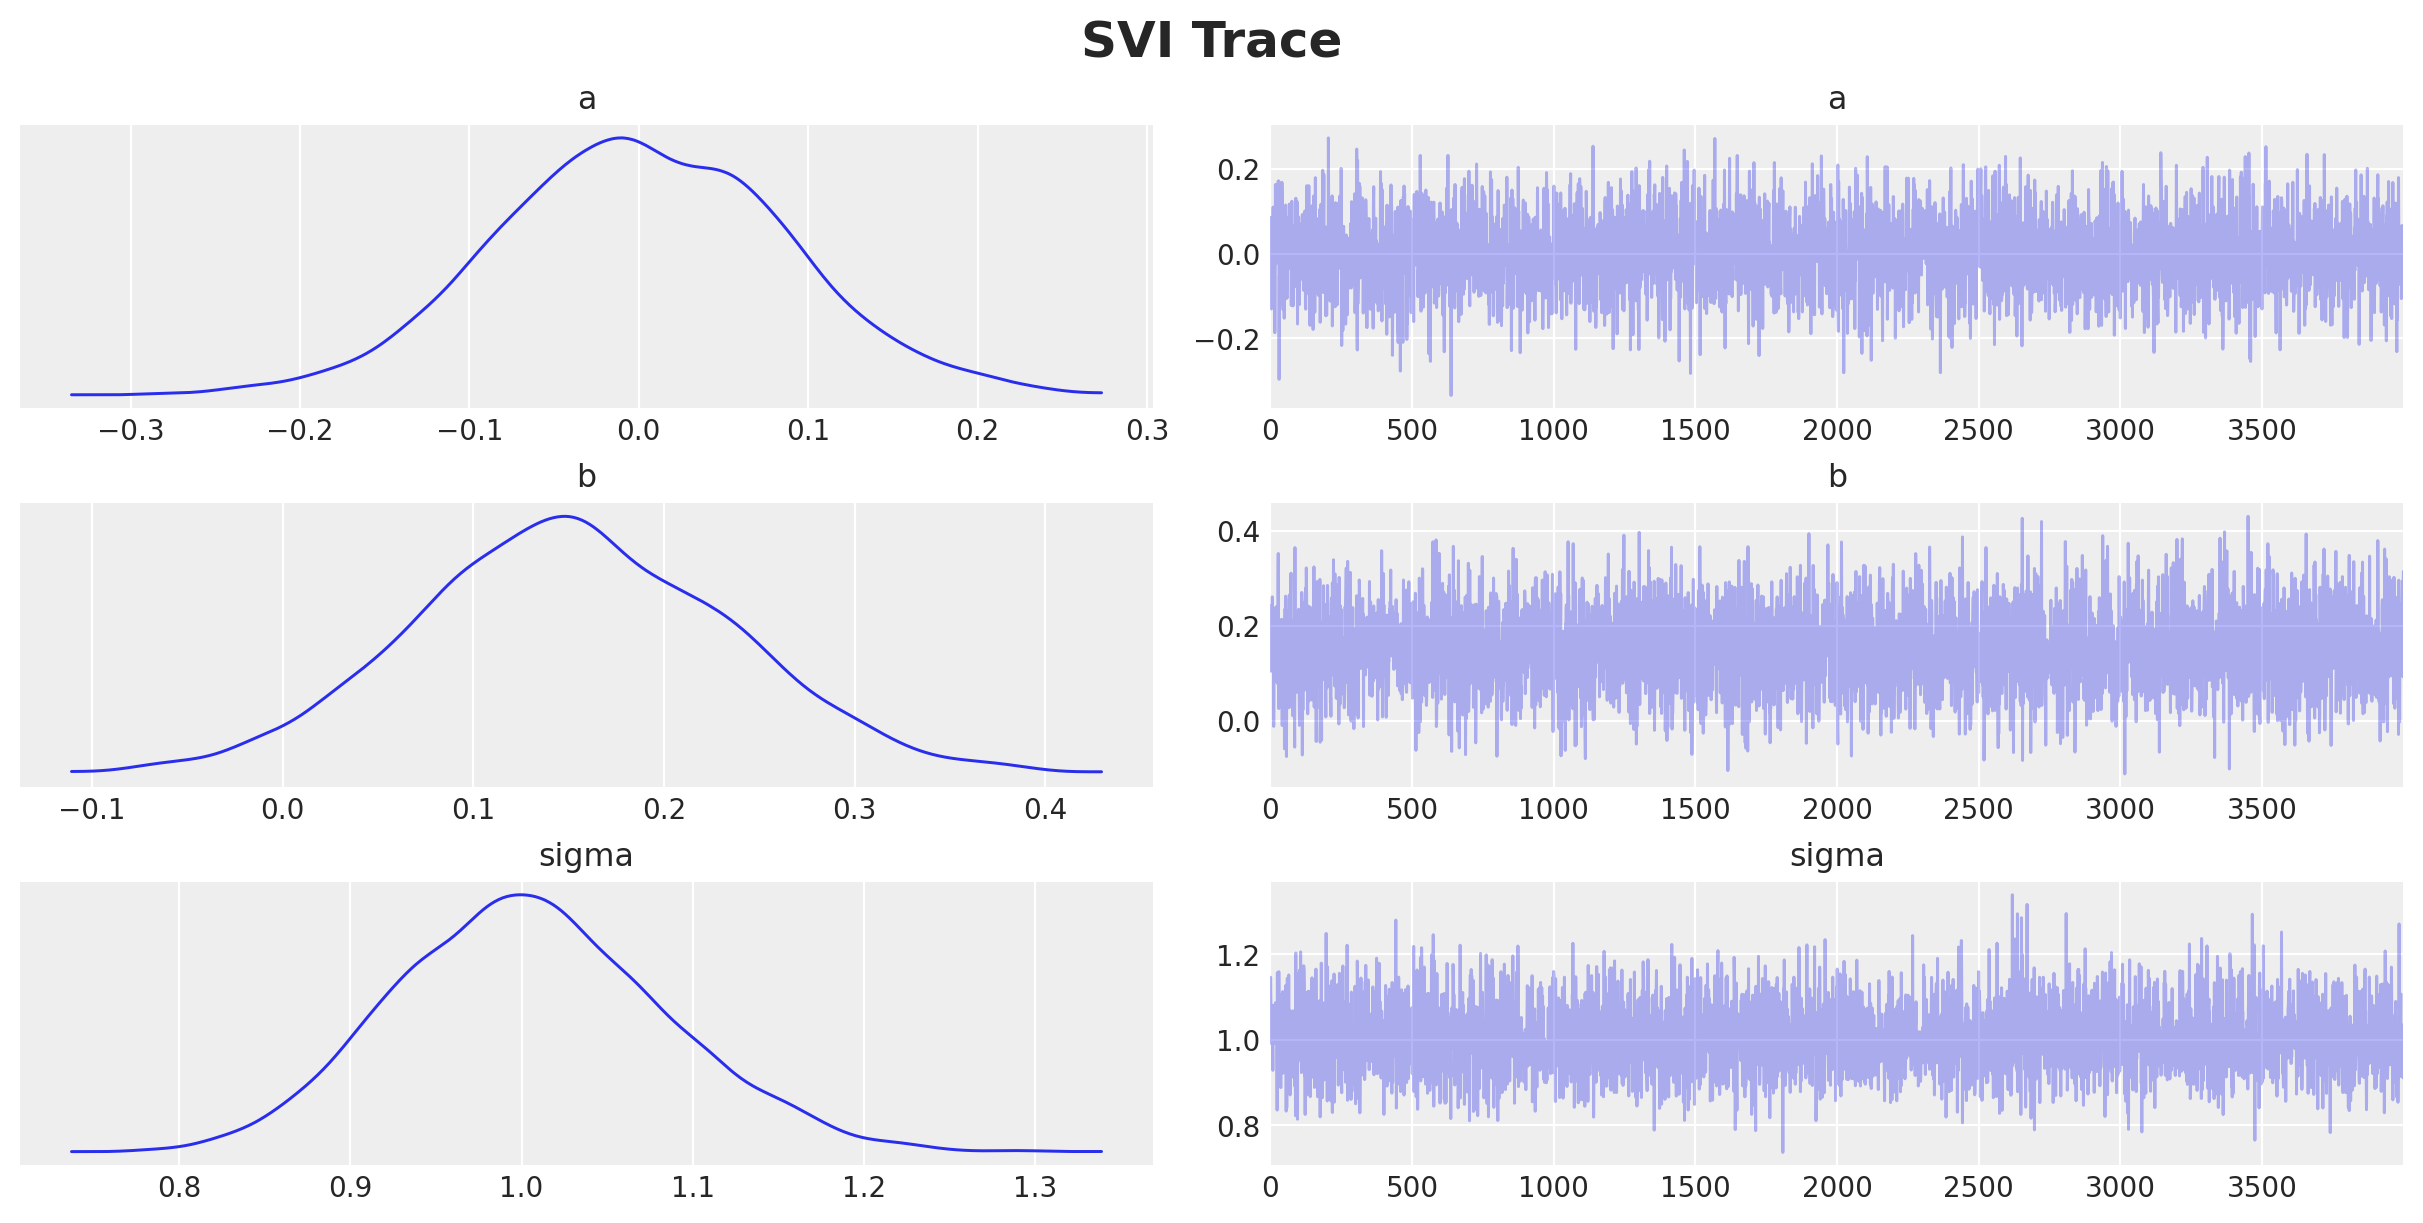

In [13]:
axes = az.plot_trace(
    data=idata_svi,
    var_names=["a", "b", "sigma"],
    compact=True,
    backend_kwargs={"layout": "constrained"},
)
plt.gcf().suptitle(t="SVI Trace", fontsize=18, fontweight="bold")

[Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

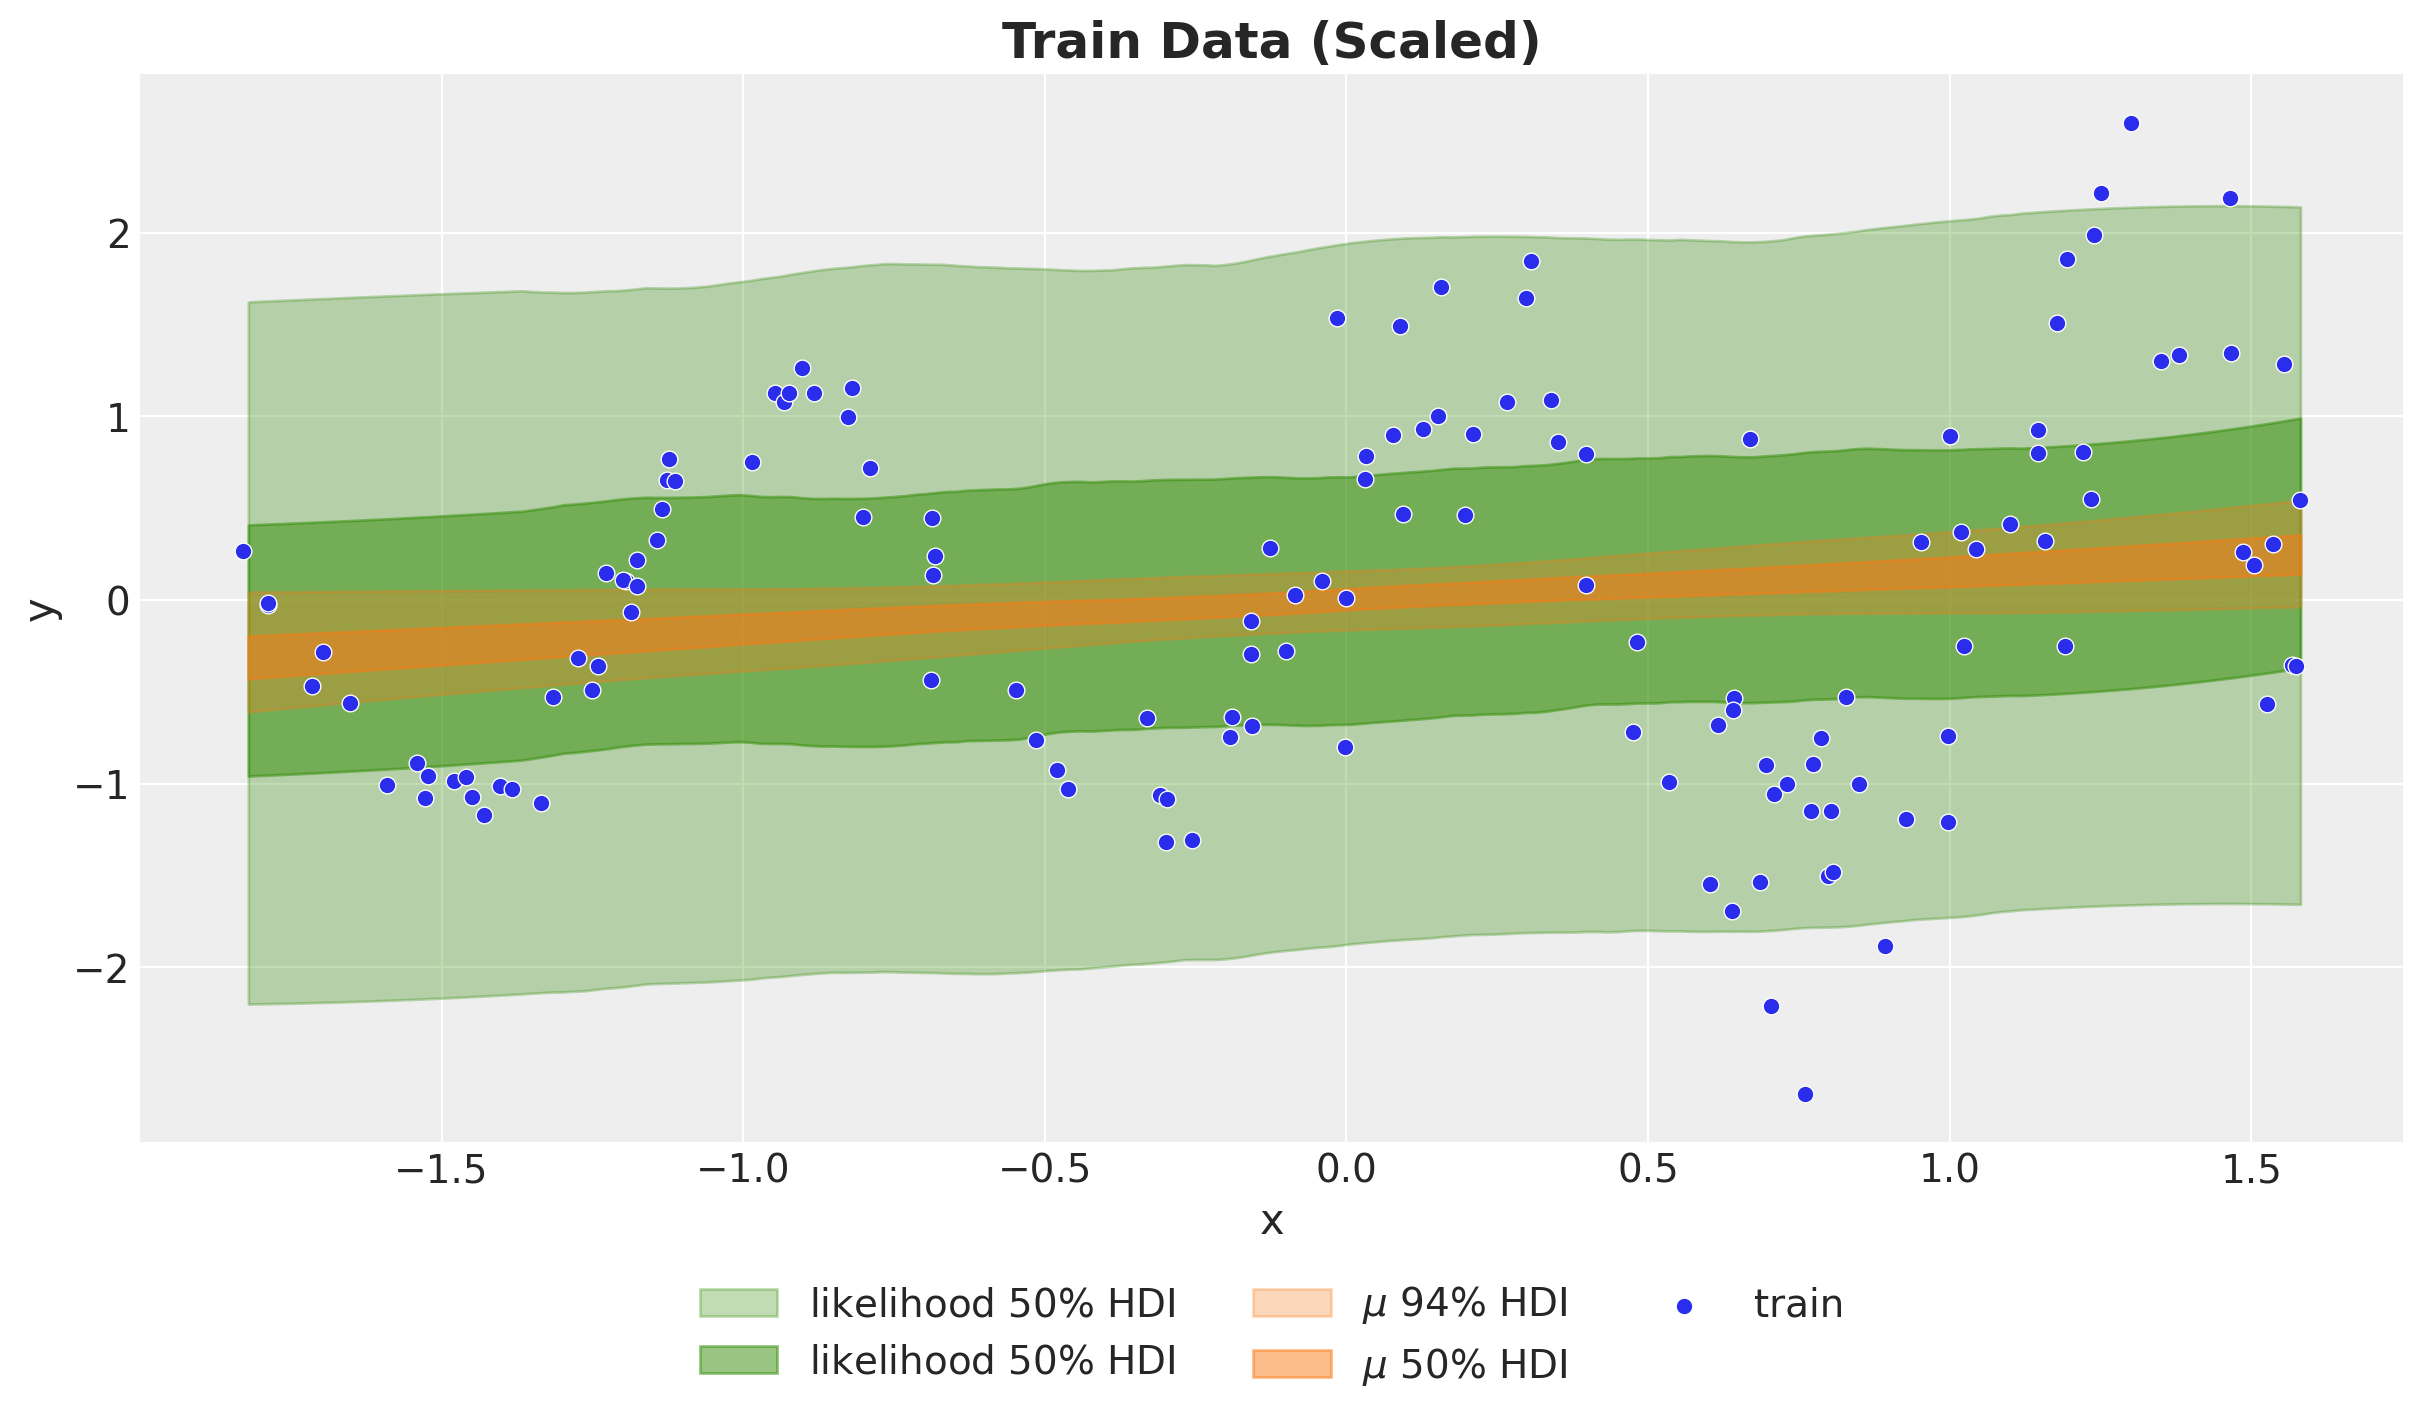

In [14]:
fig, ax = plt.subplots()
az.plot_hdi(
    x=x_train_scaled,
    y=idata_svi.posterior_predictive["likelihood"],
    hdi_prob=0.94,
    color="C2",
    fill_kwargs={"label": r"likelihood $50\%$ HDI", "alpha": 0.3},
    ax=ax,
)
az.plot_hdi(
    x=x_train_scaled,
    y=idata_svi.posterior_predictive["likelihood"],
    hdi_prob=0.50,
    color="C2",
    fill_kwargs={"label": r"likelihood $50\%$ HDI", "alpha": 0.5},
    ax=ax,
)
az.plot_hdi(
    x=x_train_scaled,
    y=idata_svi.posterior_predictive["mu"],
    hdi_prob=0.94,
    color="C1",
    fill_kwargs={"label": r"$\mu$ $94\%$ HDI", "alpha": 0.3},
    ax=ax,
)
az.plot_hdi(
    x=x_train_scaled,
    y=idata_svi.posterior_predictive["mu"],
    hdi_prob=0.50,
    color="C1",
    fill_kwargs={"label": r"$\mu$ $50\%$ HDI", "alpha": 0.5},
    ax=ax,
)
sns.scatterplot(x=x_train_scaled, y=y_train_scaled, color="C0", label="train", ax=ax)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3)
ax.set_title(label="Train Data (Scaled)", fontsize=18, fontweight="bold")
ax.set(xlabel="x", ylabel="y")